In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [59]:
def honestBlocksBernoulli(a, b, p, E):
    expr1 = (1-a)/(a*p*(1-np.exp(-b+E))+a*(1-p)*(1-np.exp(-b)))
    expr2 = expr1 + 2*((1-a)**2) + a*(1-a)
    return expr2

def honestExtrasBernoulli(a, b, p, E):
    return honestBlocksBernoulli(a, b, p, E)

def attackExtrasBernoulli(a, b, p, E):
    num   = np.exp(-b+E) + (1-np.exp(-b+E))*(1-((1-a)**2))
    den   = (1-p)*(1-np.exp(-b)) + p*(1-np.exp(-b+E))
    expr1 = num / den
    expr2 = a**3 / ((1-2*a)*(1-a))
    expr3 = expr1 + a*(1-a) + a**2 + a/(1-a) + expr2
    return expr3

def extraRewBernoulli(a, b, p, E):
    A = attackExtrasBernoulli(a, b, p, E)
    H = honestExtrasBernoulli(a, b, p, E)
    return A/(A+H)

In [67]:
alphas = [0.2, 0.25, 0.3, 0.35, 0.4]
betas  = np.arange(1, 4, 0.01)
ps     = [0.2, 0.5, 0.8] # using E=1

In [68]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
            temp2.append(extraRewBernoulli(a=a, b=b, p=p, E=1.))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 300, 3)

In [69]:
def simExtraRewardBernoulli(a, b, p, E, n):
    state = [0,0] # (attacker, honest)

    honestBern = 0
    attackBern = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-E):
                    state      = [1,0]
                    prevBern   = bernRews
                elif not bernRews and execRews < b:
                    state      = [1,0]
                    prevBern   = 0
                else:
                    attackBern += bernRews
            else:
                honestBern += bernRews
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                attackBern += (bernRews + prevBern)
                prevBern    = 0
            else:
                sample        = np.random.uniform()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBern += (prevBern + nextBern)
                else:
                    # honest bern is a random trial
                    prevHonest  = np.random.binomial(1, p=p)
                    honestBern += (prevHonest + nextBern)
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            if state[0] < 2:
                raise KeyError('impossible state')
            attackBern += (state[0]-2) * p * E

            # 0'' state
            attBlock = np.random.binomial(1, a)
            bernRews = np.random.binomial(1, p=p)
            if attBlock:
                attackBern += bernRews
            else:
                honestBern += bernRews
            state = [0,0]
 
    return honestBern, attackBern

In [70]:
simBetas = np.arange(1, 4.01, 0.25)
simBetas

array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
       3.75, 4.  ])

In [71]:
simsRes = []
for a in alphas:
    temp1 = []
    for b in tqdm(simBetas):
        temp2 = []
        for p in ps:
            hb, ab = simExtraRewardBernoulli(a=a, b=b, p=p, E=1., n=int(1e5))
            temp2.append(ab/(ab+hb))
        temp1.append(temp2)
    simsRes.append(temp1)
simsRes = np.array(simsRes)
simsRes.shape

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


(5, 13, 3)

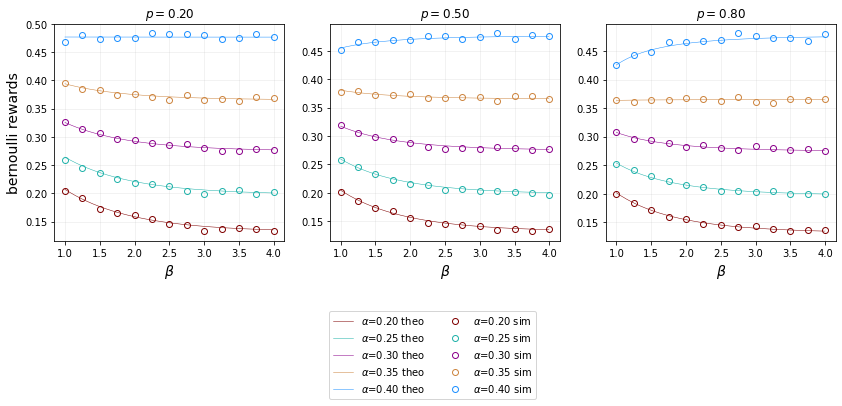

In [72]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=0.5, color=colors[j], 
                        label=r'$\alpha$={:0.2f} theo'.format(a))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theo'.format(a))

for i in range(3):
    ax = axarr[i]
    for j, a in enumerate(alphas):
        marker, = ax.plot(simBetas, simsRes[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} sim'.format(a))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} sim'.format(a))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'bernoulli rewards', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()